$$
H = H_0 + H_I
$$

$$
H_0 = \hbar \omega_c a^{\dagger} a+  \hbar \omega_a \sum_{i=1}^{N_{\text{atoms}}} \sigma_+^{(i)} \sigma_-^{(i)} + \hbar \sum_{i,j=1}^{N_\text{{atoms}}} J_{ij} \sigma_+^{(i)} \sigma_-^{(j)} \quad \text{,} \quad J_{ij} = \frac{\alpha}{|r_i - r_j|^3}
$$

$$
H_I = \hbar  g(t) D \cdot (a^{\dagger} + a)
\quad \text{,} \quad D = \mu \sum_{i=1}^{N_{\text{atoms}}} \sigma_+^{(i)} + \sigma_-^{(i)}
\quad \text{,} \quad g(t) \propto \Omega_{coupling} * \delta(t)
$$

### Decay operators single case
$$
C_{\text{decay}}^{(i)} = \sqrt{\gamma_0} \sigma_-^{(i)} \quad
C_{\text{dephase}}^{(i)} = \sqrt{\gamma_\phi} \sigma_z^{(i)}
$$

In [65]:
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt
from qutip import *
import numpy as np
import itertools
import os

# Matplotlib Einstellungen gemäß den LaTeX-Caption-Formatierungen
plt.rcParams.update({
#    'text.usetex': True,              # Enable LaTeX for text rendering
#    'font.family': 'serif',           # Use a serif font family
#    'font.serif': 'Palatino',         # Set Palatino as the serif font
#    'text.latex.preamble': r'\usepackage{amsmath}',
#    'font.size': 20,                   # Font size for general text
#    'axes.titlesize': 20,              # Font size for axis titles
#    'axes.labelsize': 20,              # Font size for axis labels
#    'xtick.labelsize': 20,             # Font size for x-axis tick labels
#    'ytick.labelsize': 20,             # Font size for y-axis tick labels
#    'legend.fontsize': 20,             # Font size for legends
#    'figure.figsize': [8, 6],          # Size of the plot (width x height)
#    'figure.autolayout': True,         # Automatic layout adjustment
#    'savefig.format': 'svg',           # Default format for saving figures
#    'figure.facecolor': 'none',        # Make the figure face color transparent
#    'axes.facecolor': 'none',          # Make the axes face color transparent
#    'savefig.transparent': True        # Save figures with transparent background
})
output_dir = os.getcwd()  # Gets the current working directory
os.makedirs(output_dir, exist_ok=True)

# allows for interactive plots
#%matplotlib notebook

# =============================
# SYSTEM PARAMETERS
# =============================
# Energy Landscape (Natural Units: c = 1, hbar = 1)
fixed_lam = 1.0                 # Fixed wavelength (arbitrary units)
alpha = 1.0                     # Coupling strength of dipoles (Fine structure constant?)

# Atomic Parameters
omega_a = 2 * np.pi / fixed_lam # Energy splitting of the atom (ground state = 0)
omega_c = 1 * omega_a           # energysplitting of the field  Rabi freq coupling to laser mu = 1 * omega_a                    # Dipole matrix element of each atom
mu = 1 * omega_a                # Dipole matrix element of each atom
omega_R     = 10 * omega_a # energysplitting of the field  Rabi freq coupling to laser field  for first 2 lasers  -> E_field_0 dot dot Dip_op, parallel

# Lindblad Operators (Decay and Dephasing Rates)
gamma_0 = 0.2                   # Decay rate of the atoms
gamma_kappa = 0.2               # Decay rate of the cavity
gamma_phi = 0.1                 # Dephasing rate of the atoms

# =============================
# TOPOLOGY CONFIGURATION
# =============================
n_chains = 1                    # Number of chains
n_rings = 1                     # Number of rings
N_atoms = n_chains * n_rings    # Total number of atoms
distance = 1.0                  # Distance between atoms (scaled by fixed_lam)

# =============================
# TIME EVOLUTION PARAMETERS
# =============================
t_max           = 60                    # Maximum simulation time
fine_steps      = 400                   # Number of steps for high-resolution
fine_spacing    = t_max / fine_steps    # high resolution
sparse_spacing  = 20 * fine_spacing     # for T
# Time Arrays

Delta_ts = [1*fine_spacing] * 3 # Pulse widths

times   = np.arange(0, t_max, fine_spacing)       # High-resolution times array to do the evolutions
first_entry = np.ceil((Delta_ts[1] + Delta_ts[2]) / sparse_spacing) * sparse_spacing
last_entry = np.floor((t_max - (2 * Delta_ts[0] + Delta_ts[1] + Delta_ts[2])) / sparse_spacing) * sparse_spacing
times_T = np.arange(first_entry, last_entry, sparse_spacing)

# =============================
# GEOMETRY DEFINITIONS
# =============================
def chain_positions(distance, N_atoms):
    """ Generate atomic positions in a linear chain. """
    return np.array([[0, 0, i * distance] for i in range(N_atoms)])

def z_rotation(angle):
    """ Generate a 3D rotation matrix around the z-axis. """
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle), np.cos(angle), 0],
        [0, 0, 1]
    ])

def ring_positions(distance, n_chains):
    """ Generate atomic positions in a ring. """
    dphi = 2 * np.pi / n_chains
    radius = 0 if n_chains == 1 else distance / (2 * np.sin(np.pi / n_chains))
    return np.array([z_rotation(dphi * i) @ [radius, 0, 0] for i in range(n_chains)])

def cyl_positions(distance, N_atoms, n_chains):
    """ Generate atomic positions in a cylindrical structure. """
    Pos_chain = chain_positions(distance, N_atoms // n_chains)
    Pos_ring = ring_positions(distance, n_chains)
    return np.vstack([Pos_chain + Pos_ring[i] for i in range(n_chains)])

# =============================
# MORE FUNCTIONS
# =============================
def sample_frequencies(E0, Delta, N_atoms):
    """ Sample atomic frequencies from a Gaussian distribution. """
    return np.random.normal(loc=E0, scale=Delta / 2, size=N_atoms)

def plot_positive_color_map(x, y, data, T = np.inf, space="real", type="real", positive=False, safe=False):
    """
    Create a color plot of 2D functional data for positive x and y values only.

    Parameters:
        x (np.array): 1D array of x values.
        y (np.array): 1D array of y values.
        data (np.array): 2D array of data values aligned with x and y.
        T (float): Temperature parameter to include in plot title and file name.
        space (str): Either 'real' or 'freq' specifying the space of the data.
        type (str): Type of data ('real', 'imag', 'abs', or 'phase'). Used only if space="freq".
        positive (bool): Whether to use only positive values of x and y.
        safe (bool): If True, saves the plot to a file.

    Returns:
        None
    """
    # Convert x and y into 1D arrays if they're not
    x = np.array(x)
    y = np.array(y)

    if positive:
        # Filter for positive x and y values
        positive_x_indices = np.where(x > 0)[0]  # Indices where x > 0
        positive_y_indices = np.where(y > 0)[0]  # Indices where y > 0
        x = x[positive_x_indices]
        y = y[positive_y_indices]
        data = data[np.ix_(positive_y_indices, positive_x_indices)]

    label = r"$\propto E_{out} / E_0$"# \quad \propto \quad P / E_0
    if space == "real":
        colormap = "viridis"
        title = f"Real space 2D Spectrum (arb. units)"
        if T != np.inf:
            title += f" at T ={T:.2f}"
        x_title = r"$t_{det}$ (arb. units)"
        y_title = r"$\tau_{coh}$ (arb. units)"
    elif space == "freq":
        colormap = "plasma"
        if type == "real":
            title = f"Freq space, Real 2D Spectrum (arb. units)"
            data = np.real(data)
        elif type == "imag":
            title = f"Freq space, Imag 2D Spectrum (arb. units)"
            data = np.imag(data)
        elif type == "abs":
            title = f"Freq space, Abs 2D Spectrum (arb. units)"
            data = np.abs(data)
        elif type == "phase":
            title = "Freq space, Phase 2D Spectrum (arb. units)"
            data = np.angle(data)
        else:
            raise ValueError("Invalid Type. Must be 'real', 'imag', 'abs', or 'phase'.")

        if T != np.inf:
            title += f" at T ={T:.2f}"

        title += f" at T ={T:.2f}"
        x_title = r"$\omega_{t_{det}}$ (arb. units)"
        y_title = r"$\omega_{\tau_{coh}}$ (arb. units)"

    else:
        raise ValueError("Invalid space. Must be 'real' or 'freq'.")

    # Check and adjust the dimensions of x, y, and data
    if data.shape[1] != len(x):
        raise ValueError(f"Length of x ({len(x)}) must match the number of columns in data ({data.shape[1]}).")
    if data.shape[0] != len(y):
        raise ValueError(f"Length of y ({len(y)}) must match the number of rows in data ({data.shape[0]}).")

    # Add 1 to the dimensions of x and y for correct pcolormesh behavior
    x = np.concatenate([x, [x[-1] + (x[-1] - x[-2])]])  # Add an extra value for the last x edge
    y = np.concatenate([y, [y[-1] + (y[-1] - y[-2])]])  # Add an extra value for the last y edge

    # Plot the color map
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(x, y, data / omega_R, shading="auto", cmap=colormap)
    plt.colorbar(label=label)
    plt.title(title)
    plt.xlabel(x_title)
    plt.ylabel(y_title)

    # Save the plot if safe is True
    if safe and output_dir is not None:
        file_name_combined = (
            f"Classical_lam{fixed_lam:.1f}_alpha={alpha:.2f}_g_0{gamma_0:.2f}_g_phi{gamma_phi:.2f}_"
            f"{n_rings}x{n_chains}_dist={distance:.2f}_positive={positive}_space={space}"
        )
        if space == "freq":
            file_name_combined += f"_type={type}"
        file_name_combined += ".svg"
        save_path_combined = os.path.join(output_dir, file_name_combined)
        plt.savefig(save_path_combined)

    plt.show()

def Hamilton0(distance, n_rings, n_chains):
    N_atoms = n_chains * n_rings
    Pos = cyl_positions(distance, N_atoms, n_chains)
    H_a = 0
    for a in range(N_atoms):
        for b in range(N_atoms):
            op = sm_list[a].dag() * sm_list[b]
            if a != b:
                ra, rb = Pos[a, :], Pos[b, :]
                H_a += alpha / (np.linalg.norm(rb-ra)) * op
            else:
                H_a += omega_a * op        # Diagonals except for |0><0|
    H_c = omega_c * ket2dm(cav_e)
    return tensor(H_c, qeye(N_atoms+1)) + tensor(qeye(2), H_a)

def get_times_for_T(T, spacing=fine_spacing):
    # Adjust the first and last entries of times_tau
    first_tau = np.ceil((Delta_ts[0] + Delta_ts[1]) / spacing) * spacing
    last_tau = np.floor((t_max - Delta_ts[2] - T - Delta_ts[0]) / spacing) * spacing
    times_tau = np.arange(first_tau, last_tau, spacing)
    # Adjust the first and last entries of times_t
    first_t = np.ceil(Delta_ts[2] / spacing) * spacing
    last_t = np.floor((t_max - Delta_ts[0] - T - 2 * Delta_ts[2]) / spacing) * spacing
    times_t = np.arange(first_t, last_t, spacing)

    return times_tau, times_t
#for i in range(len(times_T)):  # Use range to iterate over indices
#    # Get the result once and store it in a variable
#    result = get_times_for_T(times_T[i])
#
#    # Unpack the result for easier access
#    first_set = result[0]
#    second_set = result[1]
#
#    # Print the desired elements from the result in a formatted manner
#    print(f"Time index {i}:")
#    print(f"  First set: {first_set[0]} {first_set[1]} {first_set[-1]}, {len(first_set)* sparse_spacing}")
#    print(f"  Second set: {second_set[0]} {second_set[1]} {second_set[-1]}, {len(first_set)* sparse_spacing}")
#    print("-" * 40)  # Separator for better readability between each iteratio
#
# =============================
# TIME-DEPENDENT FIELD
# =============================
def El_field(t, args):
    """ Define a time-dependent electric field pulse. """
    t0, Delta, omega, phi, E0 = args['time'], args['Delta'], args['omega'], args['phi'], args['E0']
    E = np.exp(1j * (omega * t + phi))
    E += np.conjugate(E)
    E *= np.cos(np.pi * (t - t0) / (2 * Delta))**2 * np.heaviside(t - (t0 - Delta), 0) * np.heaviside(t0 + Delta - t, 0)
    return E0 * E


# =============================
# QUANTUM SYSTEM INITIALIZATION
# =============================
# Define Atomic States
# Define the ground & the excited states
# atomic dofs
atom_g = basis(N_atoms+1, 0)
atom_es = [basis(N_atoms + 1, i) for i in range(1, N_atoms + 1)]

# cavity dofs
cav_g = basis(2, 0)
cav_e = basis(2, 1)

# initial state
psi_ini = tensor(cav_e, atom_g) # = |1>_gamma ø |g>_atom

# combined dofs
sm_list = []    # lowering operators of atomic system
Dip_op = 0      # collective sigma_x operator for the system
Sigma_m = 0
for i in range(N_atoms):
    op = atom_g * atom_es[i].dag()     #|0><i|, cavity is unaffected
    sm_list.append(op)
    Sigma_m += mu * op
    Dip_op += mu * (op + op.dag())


# Define Lowering Operators
sm_list = [atom_g * atom_es[i].dag() for i in range(N_atoms)]
Dip_op = sum(mu * (op + op.dag()) for op in sm_list)                # Collective dipole operator

# Define System Hamiltonian
H0 = Hamilton0(distance, n_rings, n_chains)

# =============================
# COLLAPSE OPERATORS
# =============================
c_op2 = [np.sqrt(gamma_0) * tensor(qeye(2), op) for op in sm_list]                         # Individual atom decays
c_op4 = [np.sqrt(gamma_phi) * tensor(qeye(2), commutator(op.dag(), op)) for op in sm_list] #
c_op_list = c_op2 + c_op4 + [np.sqrt(gamma_kappa) * tensor(destroy(2), qeye(N_atoms+1))]  # Combine all collapse operators + collapse of the cacity

e_op_list = ([tensor(qeye(2), ket2dm(atom_g))] +                                        # ground state
             [tensor(qeye(2), ket2dm(atom_es[i])) for i in range(N_atoms)] +            # excited states
             [tensor(create(2) * destroy(2), qeye(N_atoms+1))])# +                        # photon excitation number
#             [Sigma_m.dag() / mu * Sigma_m / mu])                                       # atom   excitation number

# =============================
# SYSTEM EVOLUTION
# =============================
Omegas = [omega_R, omega_R, omega_R * 1e-1]   # Rabi frequencies
omegas = [omega_a] * 3                      # Laser frequencies (on resonance)

I = (tensor(qeye(2), Dip_op) * tensor(destroy(2) + create(2), qeye(N_atoms+1))).unit()

HI = [-I, El_field]                    # Interaction Hamiltonian
H = [H0, HI]

options = Options(store_states=True)        # safe the states from qutip calculation

phases = [-i * np.pi / 2 for i in range(4)] # GIVES WEIRD RESULTS

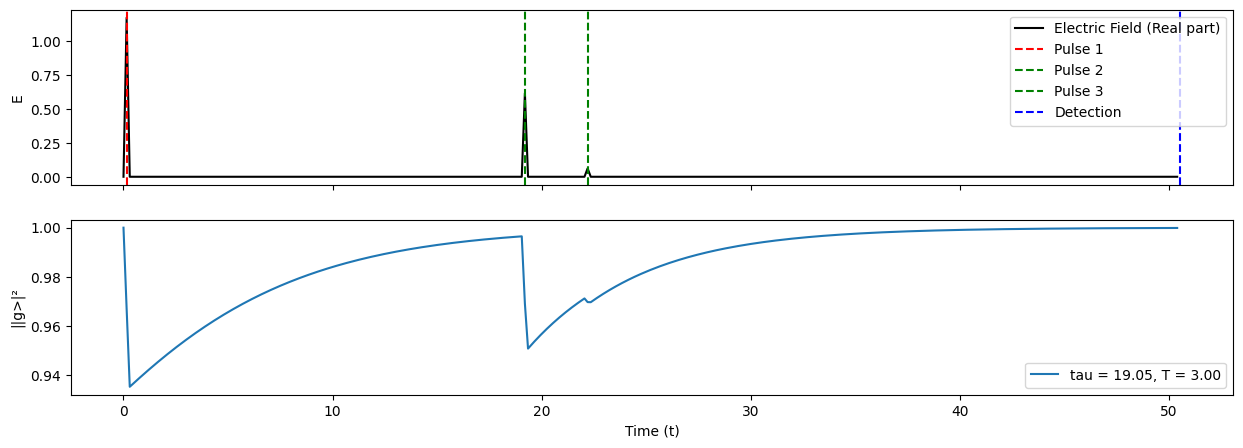

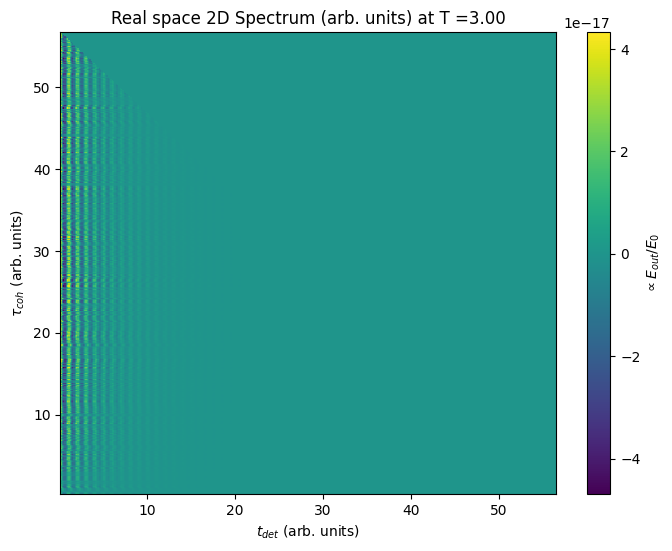

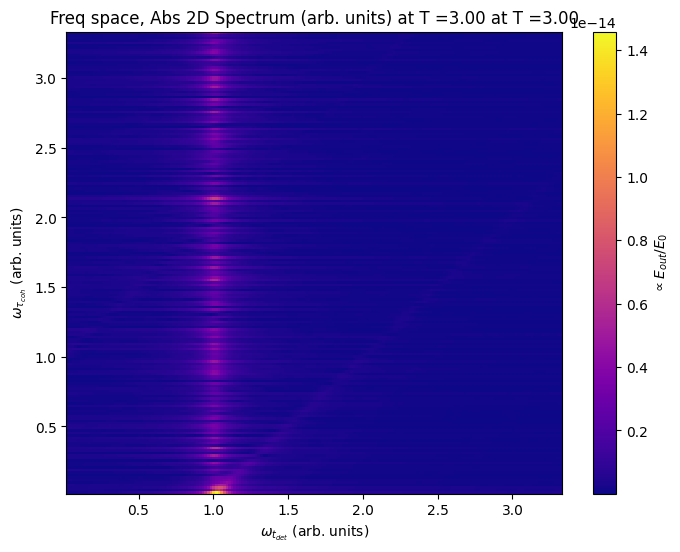

In [66]:
def ohmic_spectrum(w):
    if w == 0.0: # dephasing inducing noise
        return gamma_phi
    else: # relaxation inducing noise
        return gamma_0**2 * np.exp(-w) * (w > 0.0)

## Calculations

### Compute Pulse
def compute_pulse(psi_ini, times, phi, i):
    args = {
        'phi': phi,
        'time': times[0] + Delta_ts[i],
        'omega': omegas[i],
        'Delta': Delta_ts[i],
        'E0': Omegas[i]
    }
    result = brmesolve(H, psi_ini, times, a_ops=[(-I, ohmic_spectrum)], e_ops=e_op_list, c_ops=c_op_list, args=args, options=options)
    return result

### Compute Two-Dimensional Polarization
def compute_two_dimensional_polarization(T_val, phi_1, phi_2):
    tau_values, t_values = get_times_for_T(T_val)

    data = np.zeros((len(tau_values), len(t_values)))

    index_0 = np.abs(times - (tau_values[-1] - Delta_ts[1] + Delta_ts[0])).argmin()  # Find the closest index to reduce computation time
    times_0 = times[:index_0+1] - times[0]

    data_1  = compute_pulse(psi_ini, times_0, phi_1, 0)

    for tau_idx, tau in enumerate(tau_values):
        i       = np.abs(tau_values[tau_idx] - (times_0 + Delta_ts[1] - Delta_ts[0])).argmin()
        psi_1   = data_1.states[i]

        index_1 = np.abs(times - (times_0[i] + T_val - Delta_ts[1] + Delta_ts[2])).argmin()  # Find the closest index to reduce computation time
        times_1 = times[i:index_1+1] - times[i]
        data_2  = compute_pulse(psi_1, times_1, phi_2, 1)

        j = np.abs(T_val - (times_1 + Delta_ts[2] - Delta_ts[1])).argmin()

        psi_2   = data_2.states[j]
        times_2 = times[j:] - times[j]

        data_f  = compute_pulse(psi_2, times_2, 0, 2)

        for t_idx, t in enumerate(t_values):
            if t_idx + tau_idx < len(tau_values):

                k = np.abs(t_values[t_idx] - (times_2 - Delta_ts[2])).argmin()
                psi_f = data_f.states[k]
                data[tau_idx, t_idx] = expect(tensor(qeye(2), Dip_op), psi_f)

                # make one plot for this case
                if t == t_values[len(t_values)//2] and tau == tau_values[len(t_values)//3]:
                    #print(data[tau_idx, t_idx])
                    times_plot = times[:i+j+k]  # Use t_values for the x-axis

                    args0 = {
                        'phi': phi_1,
                        'time': times_0[0] + Delta_ts[0],
                        'omega': omegas[0],
                        'Delta': Delta_ts[0],
                        'E0': Omegas[0]
                    }
                    args1 = {
                        'phi': phi_2,
                        'time': times_0[i] + Delta_ts[1],
                        'omega': omegas[1],
                        'Delta': Delta_ts[1],
                        'E0': Omegas[1]
                    }
                    args2 = {
                        'phi': 0,
                        'time': times_0[i] + times_1[j] + Delta_ts[2],
                        'omega': omegas[2],
                        'Delta': Delta_ts[2],
                        'E0': Omegas[2]
                    }

                    concatenated_data = []

                    # Concatenate the data for different segments
                    concatenated_data.append(data_1.expect[0][:i])  # First part (data_1)
                    concatenated_data.append(data_2.expect[0][:j])  # Second part (data_2)
                    concatenated_data.append(data_f.expect[0][:k])  # Final part (data_f)

                    # Concatenate all parts together
                    full_expectation_values = np.concatenate(concatenated_data)
                    fig, axs = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

                    E_total = [((El_field(t, args0) + El_field(t, args1) + El_field(t, args2))) / omega_R for t in times_plot]
                    axs[0].plot(times_plot, E_total, label='Electric Field (Real part)', color='black')
                    axs[0].set_ylabel('E')

                    # Add vertical lines to mark pulse times
                    axs[0].axvline(times_0[0] + Delta_ts[0], color='r', linestyle='--', label='Pulse 1')
                    axs[0].axvline(times_0[i] + Delta_ts[1], color='g', linestyle='--', label='Pulse 2')
                    axs[0].axvline(times_0[i] + times_1[j] + Delta_ts[2], color='g', linestyle='--', label='Pulse 3')
                    axs[0].axvline(times_0[i] + times_1[j] + times_2[k], color='b', linestyle='--', label='Detection')
                    axs[0].legend()

                    # Plot Expectation Value in the second subplot
                    axs[1].plot(times_plot, full_expectation_values, label=f'tau = {tau:.2f}, T = {T_val:.2f}')
                    axs[1].set_xlabel('Time (t)')
                    axs[1].set_ylabel('||g>|²')

                    # Add labels and legend
                    plt.legend()
                    plt.show()

    return tau_values, t_values, data

### Test Computation
T_test = times_T[0]
data_test_0 = compute_two_dimensional_polarization(T_test, phases[0], phases[0])
plot_positive_color_map(data_test_0[1], data_test_0[0], data_test_0[2], T=T_test, safe=False)
tfreqs = np.fft.fftfreq(len(data_test_0[1]), d=(data_test_0[1][1] - data_test_0[1][0]))
taufreqs = np.fft.fftfreq(len(data_test_0[0]), d=(data_test_0[0][1] - data_test_0[0][0]))
plot_positive_color_map(tfreqs, taufreqs, np.fft.fft2(data_test_0[2]), positive=True, type="abs", space="freq", T=T_test, safe=False)

In [ ]:
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt
from qutip import *
import numpy as np
import itertools
import os

# =============================
# SYSTEM PARAMETERS
# =============================
# Energy Landscape (Natural Units: c = 1, hbar = 1)
fixed_lam = 1.0                 # Fixed wavelength (arbitrary units)
alpha = 1.0                     # Coupling strength of dipoles (Fine structure constant?)

# Atomic Parameters
omega_a = 2 * np.pi / fixed_lam # Energy splitting of the atom (ground state = 0)
omega_c = 1 * omega_a           # energysplitting of the field  Rabi freq coupling to laser mu = 1 * omega_a                    # Dipole matrix element of each atom
mu = 1 * omega_a                # Dipole matrix element of each atom
omega_R     = 1.0 * omega_a # energysplitting of the field  Rabi freq coupling to laser field  for first 2 lasers  -> E_field_0 dot dot Dip_op, parallel

# Lindblad Operators (Decay and Dephasing Rates)
gamma_0 = 0.2                   # Decay rate of the atoms
gamma_kappa = 0.2               # Decay rate of the cavity
gamma_phi = 0.1                 # Dephasing rate of the atoms

# =============================
# TIME EVOLUTION PARAMETERS
# =============================
t_max           = 6                    # Maximum simulation time
fine_steps      = 400                   # Number of steps for high-resolution
fine_spacing    = t_max / fine_steps    # high resolution
sparse_spacing  = 20 * fine_spacing     # for T
# Time Arrays

Delta_ts = [1*fine_spacing] * 3 # Pulse widths

times   = np.arange(0, t_max, fine_spacing)       # High-resolution times array to do the evolutions
first_entry = np.ceil((Delta_ts[1] + Delta_ts[2]) / sparse_spacing) * sparse_spacing
last_entry = np.floor((t_max - (2 * Delta_ts[0] + Delta_ts[1] + Delta_ts[2])) / sparse_spacing) * sparse_spacing
times_T = np.arange(first_entry, last_entry, sparse_spacing)

# =============================
# MORE FUNCTIONS
# =============================
def sample_frequencies(E0, Delta, N_atoms):
    """ Sample atomic frequencies from a Gaussian distribution. """
    return np.random.normal(loc=E0, scale=Delta / 2, size=N_atoms)

def plot_positive_color_map(x, y, data, T = np.inf, space="real", type="real", positive=False, safe=False):
    """
    Create a color plot of 2D functional data for positive x and y values only.

    Parameters:
        x (np.array): 1D array of x values.
        y (np.array): 1D array of y values.
        data (np.array): 2D array of data values aligned with x and y.
        T (float): Temperature parameter to include in plot title and file name.
        space (str): Either 'real' or 'freq' specifying the space of the data.
        type (str): Type of data ('real', 'imag', 'abs', or 'phase'). Used only if space="freq".
        positive (bool): Whether to use only positive values of x and y.
        safe (bool): If True, saves the plot to a file.

    Returns:
        None
    """
    # Convert x and y into 1D arrays if they're not
    x = np.array(x)
    y = np.array(y)

    if positive:
        # Filter for positive x and y values
        positive_x_indices = np.where(x > 0)[0]  # Indices where x > 0
        positive_y_indices = np.where(y > 0)[0]  # Indices where y > 0
        x = x[positive_x_indices]
        y = y[positive_y_indices]
        data = data[np.ix_(positive_y_indices, positive_x_indices)]

    label = r"$\propto E_{out} / E_0$"# \quad \propto \quad P / E_0
    if space == "real":
        colormap = "viridis"
        title = f"Real space 2D Spectrum (arb. units)"
        if T != np.inf:
            title += f" at T ={T:.2f}"
        x_title = r"$t_{det}$ (arb. units)"
        y_title = r"$\tau_{coh}$ (arb. units)"
    elif space == "freq":
        colormap = "plasma"
        if type == "real":
            title = f"Freq space, Real 2D Spectrum (arb. units)"
            data = np.real(data)
        elif type == "imag":
            title = f"Freq space, Imag 2D Spectrum (arb. units)"
            data = np.imag(data)
        elif type == "abs":
            title = f"Freq space, Abs 2D Spectrum (arb. units)"
            data = np.abs(data)
        elif type == "phase":
            title = "Freq space, Phase 2D Spectrum (arb. units)"
            data = np.angle(data)
        else:
            raise ValueError("Invalid Type. Must be 'real', 'imag', 'abs', or 'phase'.")

        if T != np.inf:
            title += f" at T ={T:.2f}"

        title += f" at T ={T:.2f}"
        x_title = r"$\omega_{t_{det}}$ (arb. units)"
        y_title = r"$\omega_{\tau_{coh}}$ (arb. units)"

    else:
        raise ValueError("Invalid space. Must be 'real' or 'freq'.")

    # Check and adjust the dimensions of x, y, and data
    if data.shape[1] != len(x):
        raise ValueError(f"Length of x ({len(x)}) must match the number of columns in data ({data.shape[1]}).")
    if data.shape[0] != len(y):
        raise ValueError(f"Length of y ({len(y)}) must match the number of rows in data ({data.shape[0]}).")

    # Add 1 to the dimensions of x and y for correct pcolormesh behavior
    x = np.concatenate([x, [x[-1] + (x[-1] - x[-2])]])  # Add an extra value for the last x edge
    y = np.concatenate([y, [y[-1] + (y[-1] - y[-2])]])  # Add an extra value for the last y edge

    # Plot the color map
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(x, y, data / omega_R, shading="auto", cmap=colormap)
    plt.colorbar(label=label)
    plt.title(title)
    plt.xlabel(x_title)
    plt.ylabel(y_title)

    # Save the plot if safe is True
    if safe and output_dir is not None:
        file_name_combined = (
            f"Classical_lam{fixed_lam:.1f}_alpha={alpha:.2f}_g_0{gamma_0:.2f}_g_phi{gamma_phi:.2f}_"
            f"{n_rings}x{n_chains}_dist={distance:.2f}_positive={positive}_space={space}"
        )
        if space == "freq":
            file_name_combined += f"_type={type}"
        file_name_combined += ".svg"
        save_path_combined = os.path.join(output_dir, file_name_combined)
        plt.savefig(save_path_combined)

    plt.show()

def Hamilton0():
    H_a = omega_a * ket2dm(atom_es)
    H_c = omega_c * ket2dm(cav_e)
    return H_c

def get_times_for_T(T, spacing=fine_spacing):
    # Adjust the first and last entries of times_tau
    first_tau = np.ceil((Delta_ts[0] + Delta_ts[1]) / spacing) * spacing
    last_tau = np.floor((t_max - Delta_ts[2] - T - Delta_ts[0]) / spacing) * spacing
    times_tau = np.arange(first_tau, last_tau, spacing)
    # Adjust the first and last entries of times_t
    first_t = np.ceil(Delta_ts[2] / spacing) * spacing
    last_t = np.floor((t_max - Delta_ts[0] - T - 2 * Delta_ts[2]) / spacing) * spacing
    times_t = np.arange(first_t, last_t, spacing)

    return times_tau, times_t
#for i in range(len(times_T)):  # Use range to iterate over indices
#    # Get the result once and store it in a variable
#    result = get_times_for_T(times_T[i])
#
#    # Unpack the result for easier access
#    first_set = result[0]
#    second_set = result[1]
#
#    # Print the desired elements from the result in a formatted manner
#    print(f"Time index {i}:")
#    print(f"  First set: {first_set[0]} {first_set[1]} {first_set[-1]}, {len(first_set)* sparse_spacing}")
#    print(f"  Second set: {second_set[0]} {second_set[1]} {second_set[-1]}, {len(first_set)* sparse_spacing}")
#    print("-" * 40)  # Separator for better readability between each iteratio
#
# =============================
# TIME-DEPENDENT FIELD
# =============================
def El_field(t, args):
    """ Define a time-dependent electric field pulse. """
    t0, Delta, omega, phi, E0 = args['time'], args['Delta'], args['omega'], args['phi'], args['E0']
    E = np.exp(1j * (omega * t + phi))
    E += np.conjugate(E)
    E *= np.cos(np.pi * (t - t0) / (2 * Delta))**2 * np.heaviside(t - (t0 - Delta), 0) * np.heaviside(t0 + Delta - t, 0)
    return E0 * E


# =============================
# QUANTUM SYSTEM INITIALIZATION
# =============================
# Define Atomic States
# Define the ground & the excited states
# atomic dofs
N_atoms = 1
atom_g = basis(N_atoms+1, 0)
atom_es = [basis(N_atoms + 1, i) for i in range(1, N_atoms + 1)]

# cavity dofs
cav_g = basis(2, 0)
cav_e = basis(2, 1)

# initial state
psi_ini = tensor(cav_e, atom_g) # = |1>_gamma ø |g>_atom

# combined dofs
sm_list = []    # lowering operators of atomic system
Dip_op = 0      # collective sigma_x operator for the system
Sigma_m = 0
for i in range(N_atoms):
    op = atom_g * atom_es[i].dag()     #|0><i|, cavity is unaffected
    sm_list.append(op)
    Sigma_m += mu * op
    Dip_op += mu * (op + op.dag())


# Define Lowering Operators
sm_list = [atom_g * atom_es[i].dag() for i in range(N_atoms)]
Dip_op = sum(mu * (op + op.dag()) for op in sm_list)                # Collective dipole operator

# Define System Hamiltonian
H0 = Hamilton0(distance, n_rings, n_chains)

# =============================
# COLLAPSE OPERATORS
# =============================
c_op2 = [np.sqrt(gamma_0) * tensor(qeye(2), op) for op in sm_list]                         # Individual atom decays
c_op4 = [np.sqrt(gamma_phi) * tensor(qeye(2), commutator(op.dag(), op)) for op in sm_list] #
c_op_list = c_op2 + c_op4 + [np.sqrt(gamma_kappa) * tensor(destroy(2), qeye(N_atoms+1))]  # Combine all collapse operators + collapse of the cacity

e_op_list = ([tensor(qeye(2), ket2dm(atom_g))] +                                        # ground state
             [tensor(qeye(2), ket2dm(atom_es[i])) for i in range(N_atoms)] +            # excited states
             [tensor(create(2) * destroy(2), qeye(N_atoms+1))])# +                        # photon excitation number
#             [Sigma_m.dag() / mu * Sigma_m / mu])                                       # atom   excitation number

# =============================
# SYSTEM EVOLUTION
# =============================
Omegas = [omega_R, omega_R, omega_R * 1e-1]   # Rabi frequencies
omegas = [omega_a] * 3                      # Laser frequencies (on resonance)

I = (tensor(qeye(2), Dip_op) * tensor(destroy(2) + create(2), qeye(N_atoms+1))).unit()

HI = [-I, El_field]                    # Interaction Hamiltonian
H = [H0, HI]

options = Options(store_states=True)        # safe the states from qutip calculation

phases = [-i * np.pi / 2 for i in range(4)] # GIVES WEIRD RESULTS

In [69]:
# num modes
N = 2
# Hamiltonian
a = destroy(N)
H = a.dag() * a

# initial state
psi0 = basis(N, N - 1)

# times for simulation
times = np.linspace(0, 10, 100)

# solve using brmesolve
result_const = brmesolve(H, psi0, times, e_ops=[a.dag() * a])

In [ ]:
plot_expectation_values(result_const, ylabels=["<n>"]);

In [ ]:
time_dependence = "sin(t)"
H_t = [H, [a + a.dag(), time_dependence]]
result_brme = brmesolve(H_t, psi0, times, e_ops=[a.dag() * a])
import numpy as np
import matplotlib.pyplot as plt

# Assuming `result_brme` contains the expectation values for <n>
expectation_values = result_brme.expect[0]  # Adjust based on how the result is structured

# Create the time array from `times` (assuming `times` is a list or array of time points)
t_eval = np.array(times)

# Calculate sin(t)
sin_t = np.sin(t_eval)

# Plot the expectation value <n>
plt.plot(t_eval, expectation_values, label=r"$\langle n \rangle$", color='blue')

# Plot sin(t) on the same axis
plt.plot(t_eval, sin_t, label=r"$\sin(t)$", color='red', linestyle='--')

# Labels and legend
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()

# Show plot
plt.show()

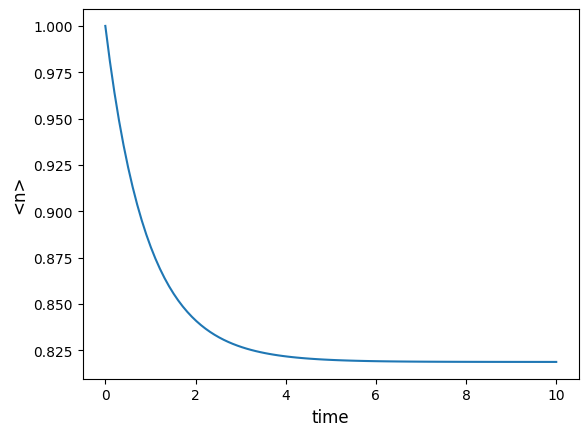

In [79]:
# setup dissipation
kappa = 0.2
a_ops = [
    ([a+a.dag(), f'sqrt({kappa}*exp(-t))'], '(w>=0)')
]
# solve
result_brme_aops = brmesolve(H, psi0, times, a_ops, e_ops=[a.dag() * a])

plot_expectation_values([result_brme_aops], ylabels=["<n>"]);

In [80]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.1.0
Numpy Version:      2.2.1
Scipy Version:      1.15.0
Cython Version:     None
Matplotlib Version: 3.10.0
Python Version:     3.12.3
Number of CPUs:     8
BLAS Info:          Generic
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/leopold/PycharmProjects/Master_thesis/.venv/lib/python3.12/site-packages/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex refer

In [81]:
qutip.cite()

@article{qutip2,
doi = {10.1016/j.cpc.2012.11.019},
url = {https://doi.org/10.1016/j.cpc.2012.11.019},
year  = {2013},
month = {apr},
publisher = {Elsevier {BV}},
volume = {184},
number = {4},
pages = {1234--1240},
author = {J.R. Johansson and P.D. Nation and F. Nori},
title = {{QuTiP} 2: A {P}ython framework for the dynamics of open quantum systems},
journal = {Computer Physics Communications}
}
@article{qutip1,
doi = {10.1016/j.cpc.2012.02.021},
url = {https://doi.org/10.1016/j.cpc.2012.02.021},
year  = {2012},
month = {aug},
publisher = {Elsevier {BV}},
volume = {183},
number = {8},
pages = {1760--1772},
author = {J.R. Johansson and P.D. Nation and F. Nori},
title = {{QuTiP}: An open-source {P}ython framework for the dynamics of open quantum systems},
journal = {Computer Physics Communications}
}


In [83]:
result_brme_aops_sum = brmesolve(H, psi0, times, a_ops, e_ops=[a.dag() * a])
assert np.allclose(result_const.expect[0], 1.0)

# compare result from brme with a_ops to analytic solution
analytic_aops = (N - 1) * np.exp(-kappa * (1.0 - np.exp(-times)))
assert np.allclose(result_brme_aops.expect[0], analytic_aops)

assert np.all(np.diff(result_brme_aops_sum.expect[0]) <= 0.0)

Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[0.23529412]
 [0.94117647]
 [0.05882353]
 [0.23529412]] Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 12.48901418   0.           0.98290673   0.62831853]
 [  0.          -0.07735644   0.62831853   0.98290673]
 [  0.98290673   0.62831853   0.07735644   0.        ]
 [  0.62831853   0.98290673   0.         -12.48901418]]


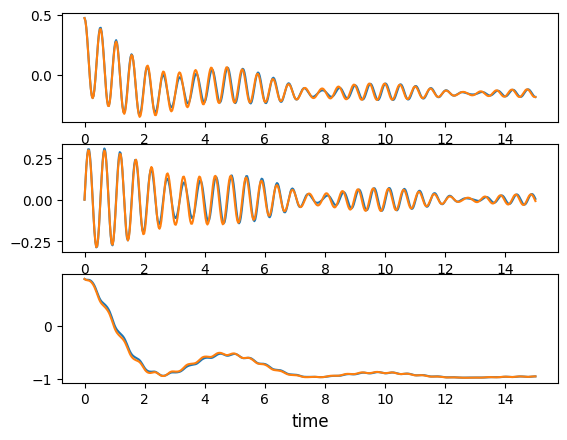

In [105]:
pi = np.pi
w       = np.array([1.0,1.0])*2*pi
# qubit angular frequency
theta   = np.array([0.025,0.0])*2*pi # angle from sigma_z axis
gamma1  = [0.25, 0.35]  # qubit relaxation rate
gamma2  = [0.0, 0.0]    # qubit dephasing rate
g       = 0.1 * 2 * pi  # coupling strength

# initial state
a = 0.8
psi1 = (a*basis(2,0)+(1-a)*basis(2,1)).unit()
psi2 = ((1-a)*basis(2,0)+a*basis(2,1)).unit()
psi0 = tensor(psi1, psi2)
# times at which to evaluate expectation values
tlist = np.linspace(0, 15, 500)

# operators for qubit 1
sx1 = tensor(sigmax(), qeye(2))
sy1 = tensor(sigmay(), qeye(2))
sz1 = tensor(sigmaz(), qeye(2))
sm1 = tensor(sigmam(), qeye(2))
# operators for qubit 2
sx2 = tensor(qeye(2), sigmax())
sy2 = tensor(qeye(2), sigmay())
sz2 = tensor(qeye(2), sigmaz())
sm2 = tensor(qeye(2), sigmam())
# Hamiltonian
# qubit 1
H = w[0] * (np.cos(theta[0]) * sz1 + np.sin(theta[0]) * sx1)
# qubit 2
H += w[1] * (np.cos(theta[1]) * sz2 + np.sin(theta[1]) * sx2)

# interaction term
H += g * sx1 * sx2

# -----------------------------------------------------
# Lindblad master equation
#
c_ops = []
c_ops.append(np.sqrt(gamma1[0]) * sm1)
c_ops.append(np.sqrt(gamma1[1]) * sm2)
lme_results = mesolve(H, psi0, tlist, c_ops,e_ops=[sx1, sy1, sz1])

# -----------------------------------------------------
# Bloch-Redfield master equation
#
def ohmic_spectrum1(w):
    if w == 0.0: # dephasing inducing noise
        return 0.5 * gamma2[0]
    else: # relaxation inducing noise
        return 0.5 * gamma1[0]*w/(2*pi)*(w > 0.0)

def ohmic_spectrum2(w):
    if w == 0.0: # dephasing inducing noise
        return 0.5 * gamma2[1]
    else: # relaxation inducing noise
        return 0.5 * gamma1[1]*w/(2*pi)*(w > 0.0)

print(psi0, H)

brme_results = brmesolve(H, psi0, tlist, a_ops=[[sx1, ohmic_spectrum1], [sx2, ohmic_spectrum2]],e_ops=[sx1, sy1, sz1])
plot_expectation_values([lme_results]+[brme_results]);